<!-- <img  src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 15%; margin-right: 5%; margin-left: 17%; margin-top: 1.0em; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 0%; margin-left: 0%; margin-bottom: 2.0em;">
<img src="https://cms-docdb.cern.ch/cgi-bin/PublicDocDB/RetrieveFile?docid=3045&filename=CMSlogo_color_label_1024_May2014.png&version=3" alt="CMS" style="float: left; width: 12%; margin-left: 5%; margin-right: 5%; margin-bottom: 2.0em;"> -->
<p style="clear: both;">
<div style="text-align:center"><h1>CMS H&#8594;µµ analysis  
     <br> with Coffea package from Fermilab</h1></div>
<div style="text-align:center"><i>Author: Dmitry Kondratyev, based on example code by Lindsey Gray</i></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Search for Higgs boson decaying into two muons

This code uses awkward array toolset, and utilizing Coffea [histograms](https://coffeateam.github.io/coffea/modules/coffea.hist.html).
This also shows the analysis object syntax implemented by Coffea [JaggedCandidateArray](https://coffeateam.github.io/coffea/api/coffea.analysis_objects.JaggedCandidateMethods.html), and the usage of custom [accumulators](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html) other than histograms.  Further, it introduces the [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html) concept and the interface to apache spark.

#### SWAN env: LCG96 Python3 stack and Cloud Containers cluster

In [ ]:
# Run this cell if you do not have coffea installed (e.g. on SWAN with LCG 96Python3 stack)
!pip install --user --upgrade coffea parsl

# spark.jars.packages doesnt work with Spark 2.4 with kubernetes
!wget -N https://repo1.maven.org/maven2/edu/vanderbilt/accre/laurelin/0.5.1/laurelin-0.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-api/2.11.2/log4j-api-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-core/2.11.2/log4j-core-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/lz4/lz4-java/1.5.1/lz4-java-1.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/tukaani/xz/1.2/xz-1.2.jar

In [21]:
# Run this cell before establishing spark connection

import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':' + '/usr/local/lib/python3.6/site-packages'

In [22]:
import time
import coffea
print("Coffea version: ", coffea.__version__)

from coffea import hist, util
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea.lookup_tools import extractor, dense_lookup
from coffea.lumi_tools import LumiMask

import awkward
import uproot
import numpy as np
import numba

Coffea version:  0.6.28


In [41]:
import glob

import json

paths = json.load(open('data/datasets/datasets_2016.json'))

# TODO: add all processes 
# TODO: add possibility to load of files through XrootD

debug = True

if debug:
    samples = [
        'data_G', 
        'dy', 
        'ttjets_dl',      
        'ewk_lljj_mll50_mjj120',
        'ggh_amcPS',
        'vbf_amcPS',
        
#         'ewk_lljj_mll105_160', 
#         'st_tw_top',
#         'st_tw_antitop',
#         'ww_2l2nu',
#         'wz_3lnu',
#         'www',
#         'wwz',
#         'wzz',
#         'zzz',
        
    ]
else:
    samples = paths.keys()

fileset = {}
metadata = {}

lumi = 1
data_entries = 0

# Find ROOT files in local directories
for sample in samples:
    metadata[sample] = {}
    all_files = []
    all_files = glob.glob(paths[sample]+'*root')
    
    if debug:
        all_files = [all_files[0]]
#         if 'data' in sample:
#             all_files = all_files[0:10]
#         else:
#             all_files = [all_files[0]]
     
#     server = 'root://eoscms.cern.ch/'
    server = ''
            
    if 'data' in sample:
        for f in all_files:
            tree = uproot.open(server+f)['Events']
            data_entries += tree.numentries
    else:
        sumGenWgts = 0
        nGenEvts = 0
        for f in all_files:
            tree = uproot.open(server+f)['Runs']
            if 'NanoAODv6' in paths[sample]:
                sumGenWgts += tree.array('genEventSumw_')[0]
                nGenEvts += tree.array('genEventCount_')[0]
            else:
                sumGenWgts += tree.array('genEventSumw')[0]
                nGenEvts += tree.array('genEventCount')[0]
        metadata[sample]['sumGenWgts'] = sumGenWgts
        metadata[sample]['nGenEvts'] = nGenEvts
        
    fileset[sample] = {
        'files': [server+f for f in all_files],
        'treename': 'Events'
    }


lumi = 35860.*data_entries/645880988.
print(f"Loading {data_entries/645880988.*100}% of 2016 data.")
print(f"Integrated luminosity {lumi}/pb")


Loading 0.3457904848563215% of 2016 data.
Integrated luminosity 124.0004678694769/pb


In [42]:

puLookup = util.load('data/pileup/puLookup.coffea')
muSFFileList = [{'id'   : ("data/muon_sf/EfficienciesStudies_2016_legacy_rereco_rootfiles_RunBCDEF_SF_ID.root", "NUM_TightID_DEN_genTracks_eta_pt"),
                 'iso'   : ("data/muon_sf/EfficienciesStudies_2016_legacy_rereco_rootfiles_RunBCDEF_SF_ISO.root", "NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt"),
                 'trig'  : ("data/muon_sf/EfficienciesStudies_2016_trigger_EfficienciesAndSF_RunBtoF.root", "IsoMu24_OR_IsoTkMu24_PtEtaBins/abseta_pt_ratio"),
                 'scale' : 19.656062760/35.882515396},
                {'id'     : ("data/muon_sf/EfficienciesStudies_2016_legacy_rereco_rootfiles_RunGH_SF_ID.root", "NUM_TightID_DEN_genTracks_eta_pt"),
                 'iso'   : ("data/muon_sf/EfficienciesStudies_2016_legacy_rereco_rootfiles_RunGH_SF_ISO.root", "NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt"),
                 'trig'  : ("data/muon_sf/EfficienciesStudies_2016_trigger_EfficienciesAndSF_RunGtoH.root", "IsoMu24_OR_IsoTkMu24_PtEtaBins/abseta_pt_ratio"),
                 'scale' : 16.226452636/35.882515396}]
# TODO: check scale
# TODO: generate SF for other years

zpt_weights_file = "data/zpt/zpt_weights.histo.json"

In [43]:
import warnings
warnings.filterwarnings('ignore')

@numba.jit(parallel=True)
def apply_roccor(roch_corrector, isData, muons):
    corrections = muons.pt.ones_like()
    rnd = muons.pt.ones_like()   
    if isData:
        for iev in range(muons.shape[0]):
            for imu in range(muons.counts[iev]):
                mu = muons[iev][imu]
                corrections[iev][imu] = roch_corrector.kScaleDT(mu.charge, mu.pt, mu.eta, mu.phi)
    else:
        for iev in range(muons.shape[0]):
            for imu in range(muons.counts[iev]):
                mu = muons[iev][imu]
                if (mu.matched_gen):
                    corrections[iev][imu] = roch_corrector.kSpreadMC(mu.charge, mu.pt, mu.eta, mu.phi, mu.matched_gen.pt, 0, 0)
                else:
                    corrections[iev][imu] = roch_corrector.kSmearMC(mu.charge, mu.pt, mu.eta, mu.phi, mu.nTrackerLayers, rnd[iev][imu], 0, 0)
    return corrections

def p4_sum(obj1, obj2):
    assert(obj1.shape==obj2.shape)
    px = np.zeros(obj1.shape[0])
    py = np.zeros(obj1.shape[0])
    pz = np.zeros(obj1.shape[0])
    e = np.zeros(obj1.shape[0])
    
    for obj in [obj1, obj2]:
        px_ = obj.pt*np.cos(obj.phi)
        py_ = obj.pt*np.sin(obj.phi)
        pz_ = obj.pt*np.sinh(obj.eta)
        e_  = np.sqrt(px_**2 + py_**2 + pz_**2 + obj.mass**2)
        px = px + px_
        py = py + py_
        pz = pz + pz_
        e = e + e_
        
    pt = np.sqrt(px**2 + py**2)
    eta = np.arcsinh(pz / pt)
    phi = np.arctan2(py, px)
    mass = np.sqrt(e**2 - px**2 - py**2 - pz**2)    
    return pt, eta, phi, mass

In [56]:
# Look at ProcessorABC documentation to see the expected methods and what they are supposed to do
# https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html
class DimuonProcessor(processor.ProcessorABC):
    def __init__(self, mass_window=[76,106], do_roccor=True):
        from configuration import parameters
        self.parameters = {k:v['2016'] for k,v in parameters.items()}
#         print(self.parameters)
        self.mass_window = mass_window
        self.do_roccor = do_roccor
        event_branches = ['run', 'luminosityBlock', 'genWeight']
        muon_branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_pfRelIso04_all']
        jet_branches = ['nJet', 'Jet_pt', 'Jet_eta', 'Jet_phi', 'Jet_mass', 'Jet_qgl', 'Jet_jetId', 'Jet_puId']
        vtx_branches = ['Pileup_nTrueInt', 'PV_npvsGood'] 
        other_branches = ['MET_pt']
        event_flags = ['Flag_BadPFMuonFilter','Flag_EcalDeadCellTriggerPrimitiveFilter',
                        'Flag_HBHENoiseFilter','Flag_HBHENoiseIsoFilter',
                        'Flag_globalSuperTightHalo2016Filter','Flag_goodVertices','Flag_BadChargedCandidateFilter']
        hlt_branches = ['HLT_IsoMu24', 'HLT_IsoTkMu24']
        self._columns = event_branches + muon_branches + jet_branches +\
                        vtx_branches + other_branches + event_flags + hlt_branches

        dataset_axis = hist.Cat("dataset", "")

        axes = {}
        axes['dimuon_mass'] =  hist.Bin("dimuon_mass", r"$m_{\mu\mu}$ [GeV]", 100, self.mass_window[0], self.mass_window[1])
        axes['dimuon_pt'] = hist.Bin("dimuon_pt", r"$p_{T}(\mu\mu)$ [GeV]", 100, 0, 200)
        axes['dimuon_eta'] = hist.Bin("dimuon_eta", r"$\eta (\mu\mu)$", 100, -5, 5)
        axes['dimuon_phi'] = hist.Bin("dimuon_phi", r"$\phi (\mu\mu)$", 100, -3.2, 3.2)
        axes['dimuon_dEta'] = hist.Bin("dimuon_dEta", r"$\Delta\eta (\mu\mu)$", 100, 0, 3.5)
        axes['dimuon_dPhi'] = hist.Bin("dimuon_dPhi", r"$\Delta\phi (\mu\mu)$", 100, 0, 4)

        axes['mu1_pt'] = hist.Bin("mu1_pt", r"$p_{T}(\mu_{1})$ [GeV]", 40, 20, 200)
        axes['mu1_eta'] = hist.Bin("mu1_eta", r"$\eta (\mu_{1})$", 100, -2.5, 2.5)
        axes['mu1_phi'] = hist.Bin("mu1_phi", r"$\phi (\mu_{1})$", 100, -3.2, 3.2)
        axes['mu1_iso'] = hist.Bin("mu1_iso", r"iso$(\mu1)$", 50, 0, 0.3)
        
        axes['mu2_pt'] = hist.Bin("mu2_pt", r"$p_{T}(\mu_{2})$ [GeV]", 40, 20, 120)
        axes['mu2_eta'] = hist.Bin("mu2_eta", r"$\eta (\mu_{2})$", 100, -2.5, 2.5)
        axes['mu2_phi'] = hist.Bin("mu2_phi", r"$\phi (\mu_{2})$", 100, -3.2, 3.2)
        axes['mu2_iso'] = hist.Bin("mu2_iso", r"iso$(\mu2)$", 50, 0, 0.3)
        
        axes['jet1_pt'] = hist.Bin("jet1_pt", r"$p_{T}(jet1)$ [GeV]", 100, 20, 200)
        axes['jet1_eta'] = hist.Bin("jet1_eta", r"$\eta (jet1)$", 100, -4.7, 4.7)
        axes['jet1_phi'] = hist.Bin("jet1_phi", r"$\phi (jet1)$", 100, -3.2, 3.2)
        axes['jet1_qgl'] = hist.Bin("jet1_qgl", r"$QGL (jet1)$", 10, 0, 1)
        
        axes['jet2_pt'] = hist.Bin("jet2_pt", r"$p_{T}(jet2)$ [GeV]", 100, 20, 150)
        axes['jet2_eta'] = hist.Bin("jet2_eta", r"$\eta (jet2)$", 100, -4.7, 4.7)
        axes['jet2_phi'] = hist.Bin("jet2_phi", r"$\phi (jet2)$", 100, -3.2, 3.2)
        axes['jet2_qgl'] = hist.Bin("jet2_qgl", r"$QGL (jet2)$", 10, 0, 1)

        axes['jj_mass'] = hist.Bin("jj_mass", r"$M(jj)$ [GeV]", 100, 0, 600)
        axes['jj_pt'] = hist.Bin("jj_pt", r"$p_{T}(jj)$ [GeV]", 100, 0, 150)
        axes['jj_eta'] = hist.Bin("jj_eta", r"$\eta (jj)$", 100, -4.7, 4.7)
        axes['jj_phi'] = hist.Bin("jj_phi", r"$\phi (jj)$", 100, -3.2, 3.2)
        axes['jj_dEta'] = hist.Bin("jj_dEta", r"$\Delta\eta (jj)$", 100, 0, 3.5)
        axes['jj_dPhi'] = hist.Bin("jj_dPhi", r"$\Delta\phi (jj)$", 100, 0, 3.5)
        
        axes['njets'] = hist.Bin("njets", "njets", 10, 0, 10)
        axes['npv'] = hist.Bin("npv", "npv", 50, 0, 50)
        axes['met'] = hist.Bin("met", r"$E_{T}^{miss.}$ [GeV]", 100, 0, 200)
        
        axes['genweight'] = hist.Bin("genweight", "genweight", 50, 0, 50)
        
        variables = axes.keys()
        
        accumulators = {}
        for v in variables:
            accumulators[v] = hist.Hist("Counts", dataset_axis, axes[v])
            # TODO: add category axis and systematics axis
            # can also use an axis to plot with and w/o weights
            
        accumulators['cutflow'] = processor.defaultdict_accumulator(int)
        
#         accumulators['dimuon_mass_unbinned'] = processor.column_accumulator(np.ndarray([]))
        # request: possibility to add another axis to column_accumulator (e.g. 'dataset')
        
        self._accumulator = processor.dict_accumulator(accumulators)
    
        mu_id_vals = 0
        mu_id_err = 0
        mu_iso_vals = 0
        mu_iso_err = 0
        mu_trig_vals = 0
        mu_trig_err = 0

        for scaleFactors in muSFFileList:
            id_file = uproot.open(scaleFactors['id'][0])
            iso_file = uproot.open(scaleFactors['iso'][0])
            trig_file = uproot.open(scaleFactors['trig'][0])
            
            mu_id_vals += id_file[scaleFactors['id'][1]].values * scaleFactors['scale']
            mu_id_err += id_file[scaleFactors['id'][1]].variances**0.5 * scaleFactors['scale']
            mu_id_edges = id_file[scaleFactors['id'][1]].edges

            mu_iso_vals += iso_file[scaleFactors['iso'][1]].values * scaleFactors['scale']
            mu_iso_err += iso_file[scaleFactors['iso'][1]].variances**0.5 * scaleFactors['scale']
            mu_iso_edges = iso_file[scaleFactors['iso'][1]].edges

            mu_trig_vals += trig_file[scaleFactors['trig'][1]].values * scaleFactors['scale']
            mu_trig_err += trig_file[scaleFactors['trig'][1]].variances**0.5 * scaleFactors['scale']
            mu_trig_edges = trig_file[scaleFactors['trig'][1]].edges

        self.mu_id_sf = dense_lookup.dense_lookup(mu_id_vals, mu_id_edges)
        self.mu_id_err = dense_lookup.dense_lookup(mu_id_err, mu_id_edges)
        self.mu_iso_sf = dense_lookup.dense_lookup(mu_iso_vals, mu_iso_edges)
        self.mu_iso_err = dense_lookup.dense_lookup(mu_iso_err, mu_iso_edges)
        self.mu_trig_sf = dense_lookup.dense_lookup(mu_trig_vals, mu_trig_edges)
        self.mu_trig_err = dense_lookup.dense_lookup(mu_trig_err, mu_trig_edges)    

        self.extractor = extractor()
        self.extractor.add_weight_sets([f"* * {zpt_weights_file}"])
        self.extractor.finalize()
        self.evaluator = self.extractor.make_evaluator()

        import python.RoccoR as roccor
        # To generate RoccoR libraries:
        # cd plugin
        # make
        # cd ../
        self.roch_corrector = roccor.RoccoR(self.parameters["roccor_file"].encode('utf-8'))

    
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    
    def process(self, df):
        # TODO: move all parameters to external config
        # TODO: Add FSR recovery
        # TODO: verify PU weigths (ask at https://github.com/dnoonan08/TTGamma_LongExercise)
        # TODO: NNLOPS reweighting (ggH)
        # TODO: L1 prefiring weights
        # TODO: btag sf
        # TODO: jet PU ID sf (copy-paste my code from hepaccelerate)
        # TODO: compute dimuon_costhetaCS, dimuon_phiCS
        # TODO: compute nsoftjets
        # TODO: JEC, JER
        # TODO: event-by-event mass resolution and calibration
        # TODO: kinematic variables of multimuon-multijet system
        # TODO: Add initial categorization (ggH vs. VBF)
        # TODO: Evaluate DNN
        # TODO: Add systematic uncertainties
        
              
        output = self.accumulator.identity()
        dataset = df.metadata['dataset']
        isData = 'data' in dataset
            
        nEvts = df.shape[0]

        if isData:
            lumi_info = LumiMask(self.parameters['lumimask'])
            lumimask = lumi_info(df.run.flatten(), df.luminosityBlock.flatten())
            event_weight = np.ones(nEvts)
        else:    
            lumimask = np.ones(nEvts, dtype=bool)
            genweight = df.genWeight.flatten()
            pu_weight = puLookup(dataset, df.Pileup.nTrueInt)
            event_weight = genweight*pu_weight        
        
        hlt = np.zeros(nEvts, dtype=bool)
        for hlt_path in self.parameters['hlt']:
            hlt = hlt | df.HLT[hlt_path]

        mask = hlt & lumimask
    
        # Filter 0: HLT & lumimask
        #--------------------------------#    
        df = df[mask]
        event_weight = event_weight[mask]
        #--------------------------------# 
        
        muon_flags = np.ones(df.shape[0], dtype=bool)
        for flag in self.parameters["muon_flags"]:
            muon_flags = muon_flags & df.Muon[flag]
        
        muons = df.Muon[(df.Muon.pt > self.parameters["muon_pt_cut"]) &\
                        (abs(df.Muon.eta) < self.parameters["muon_eta_cut"]) &\
                        (df.Muon.pfRelIso04_all < self.parameters["muon_iso_cut"]) &\
                        df.Muon[self.parameters["muon_id"]] & muon_flags]
              
        two_os_muons = ((muons.counts == 2) & (muons['charge'].prod() == -1))
        
        electrons = df.Electron[(df.Electron.pt > self.parameters["electron_pt_cut"]) &\
                                     (abs(df.Electron.eta) < self.parameters["electron_eta_cut"]) &\
                                     (df.Electron[self.parameters["electron_id"]] == 1)]
        
        electron_veto = (electrons.counts==self.parameters["n_electrons"])
        
        good_pv = (df.PV.npvsGood > self.parameters["n_pv"])
        
        event_flags = np.ones(df.shape[0], dtype=bool)
        for flag in self.parameters["event_flags"]:
            event_flags = event_flags & df.Flag[flag]
            
        event_filter = (two_os_muons & electron_veto & good_pv & event_flags).flatten()
        
        
        # Filter 1: Event selection
        #--------------------------------#    
        df = df[event_filter]
        muons = muons[event_filter]
        event_weight = event_weight[event_filter]
        #--------------------------------# 

        if self.do_roccor:
            roccor_factors = apply_roccor(self.roch_corrector, isData, muons)
        else: 
            roccor_factors = muons.pt.ones_like()
        
        mu1 = muons[muons.pt.argmax()]
        mu2 = muons[muons.pt.argmin()]
        
        # correct dimuon kinematics..
        dimuon_pt, dimuon_eta, dimuon_phi, dimuon_mass = p4_sum(mu1, mu2)
        
        # gives wrong dimuon mass!
#         dimuons = JaggedCandidateArray.candidatesfromcounts(
#             np.ones(dimuon_pt.shape),
#             pt=dimuon_pt.content,
#             eta=dimuon_eta.content,
#             phi=dimuon_phi.content,
#             mass=dimuon_mass.content,
#         )

        if 'dy' in dataset:
            self.evaluator['zpt_weights/2016_value']._axes = self.evaluator['zpt_weights/2016_value']._axes[0]
            zpt_weights = self.evaluator['zpt_weights/2016_value'](dimuon_pt).flatten() # TODO: fix! (flatten probably)
            event_weight = event_weight*zpt_weights
            
#             Have to do the first line because of a bug in lookup_tools
#             For 1-dimensional histograms, _axes is a tuple, and np.searchsorted doesn't understand it
#             https://github.com/CoffeaTeam/coffea/blob/2650ad7657094f6e50ebf962a1fc1763cd2c6601/coffea/lookup_tools/dense_lookup.py#L37
#             TODO: tell developers?

#             TODO: different Zpt tune for 2017/18

        mu_pass_leading_pt = muons[(muons.pt > self.parameters["muon_leading_pt"]) &\
                                   (muons.pfRelIso04_all < self.parameters["muon_trigmatch_iso"]) &\
                                   muons[self.parameters["muon_trigmatch_id"]]]
        trig_muons = df.TrigObj[df.TrigObj.id == 13]
        muTrig = mu_pass_leading_pt.cross(trig_muons, nested = True)
        matched = (muTrig.i0.delta_r(muTrig.i1) < self.parameters["muon_trigmatch_dr"])

        # at least one muon matched with L3 object, and that muon passes pt, iso and id cuts
        trig_matched = (mu_pass_leading_pt[matched.any()].counts>0)
        
        dimuon_filter = ((mu1.pt>self.parameters["muon_leading_pt"]) & trig_matched &\
                         (dimuon_mass > self.mass_window[0]) & (dimuon_mass < self.mass_window[1])).flatten()        

        
        if not isData:
            muID = self.mu_id_sf(muons.eta.compact(), muons.pt.compact())
            muIso = self.mu_iso_sf(muons.eta.compact(), muons.pt.compact())
            muTrig = self.mu_iso_sf(abs(muons.eta.compact()), muons.pt.compact())
            muSF = (muID*muIso*muTrig).prod()
            event_weight = event_weight*muSF
#             muIDerr = self.mu_id_err(muons.eta, muons.pt)
#             muIsoerr = self.mu_iso_err(muons.eta, muons.pt)
#             muTrigerr = self.mu_iso_err(abs(muons.eta), muons.pt)
#             muSF_up = ((muID + muIDerr) * (muIso + muIsoerr) * (muTrig + muTrigerr)).prod()
#             muSF_down = ((muID - muIDerr) * (muIso - muIsoerr) * (muTrig - muTrigerr)).prod() 
  
    
        # Filter 2: Dimuon pair selection
        #--------------------------------#
        df = df[dimuon_filter]   
        mu1 = mu1[dimuon_filter] 
        mu2 = mu2[dimuon_filter] 
        muons = muons[dimuon_filter]
#         dimuons = dimuons[dimuon_filter]
        dimuon_pt = dimuon_pt[dimuon_filter]
        dimuon_eta = dimuon_eta[dimuon_filter]
        dimuon_phi = dimuon_phi[dimuon_filter]
        dimuon_mass = dimuon_mass[dimuon_filter]
        event_weight = event_weight[dimuon_filter]
        #--------------------------------#
                            
        mujet = df.Jet.cross(muons, nested=True)
        deltaR_mujet = mujet.i0.delta_r(mujet.i1)
        
        # 2016: loose jetId, loose piId        
        jet_id = (df.Jet.jetId >= 1)
        jet_puid = (((df.Jet.puId >= 4) & (df.Jet.pt < 50)) | (df.Jet.pt > 50))
        jet_selection = ((df.Jet.pt > self.parameters["jet_pt_cut"]) & (abs(df.Jet.eta) < self.parameters["jet_eta_cut"]) &\
                         jet_id & jet_puid & (df.Jet.qgl > -2) & ((deltaR_mujet>self.parameters["min_dr_mu_jet"]).all()))
        
        # TODO: check jet selections
        
        jets = df.Jet[jet_selection]
        # check if there should be this eta cut
        nBtagLoose = jets[(jets.btagDeepB>self.parameters["btag_loose_wp"]) & (abs(jets.eta)<2.5)].counts
        nBtagMedium = jets[(jets.btagDeepB>self.parameters["btag_medium_wp"])  & (abs(jets.eta)<2.5)].counts
        bjet_veto = ((nBtagLoose<2)&(nBtagMedium<1))

        dijet_cuts = False
        
        if dijet_cuts:
            min_njets = 2
        else:
            min_njets = 0
        
        jet_filter = (bjet_veto & (jets.counts>=min_njets)).flatten()

        # Filter 3: Jet filter
        #--------------------------------#
        df = df[jet_filter]   
        mu1 = mu1[jet_filter] 
        mu2 = mu2[jet_filter] 
#         dimuons = dimuons[jet_filter]
        dimuon_pt = dimuon_pt[jet_filter]
        dimuon_eta = dimuon_eta[jet_filter]
        dimuon_phi = dimuon_phi[jet_filter]
        dimuon_mass = dimuon_mass[jet_filter]
        jets = jets[jet_filter]
        jet_selection = jet_selection[jet_filter]
        event_weight = event_weight[jet_filter]
        #--------------------------------#

        one_jet = (jet_selection.any() & (jets.counts>0))
        two_jets = (jet_selection.any() & (jets.counts>1))
        
        event_weight_jet1 = event_weight[one_jet]
        event_weight_jet2 = event_weight[two_jets]
        
        # temporary - pT sorting will not stay preserved after jet corrections
#         jet1 = jets[one_jet,0]
#         jet2 = jets[two_jets,1]
        
        jet1 = JaggedCandidateArray.candidatesfromcounts(
            np.ones(jets[one_jet].shape[0]),
            pt=jets[one_jet,0].pt.flatten(),
            eta=jets[one_jet,0].eta.flatten(),
            phi=jets[one_jet,0].phi.flatten(),
            mass=jets[one_jet,0].mass.flatten(),
            qgl=jets[one_jet,0].qgl.flatten()
        )
        
        jet2 = JaggedCandidateArray.candidatesfromcounts(
            np.ones(jets[two_jets].shape[0]),
            pt=jets[two_jets,1].pt.flatten(),
            eta=jets[two_jets,1].eta.flatten(),
            phi=jets[two_jets,1].phi.flatten(),
            mass=jets[two_jets,1].mass.flatten(),
            qgl=jets[two_jets,1].qgl.flatten()
        )
        
        if(dijet_cuts): # VBF category
            dijet_pairs = jets[two_jets, 0:2]

            dijet_jca = JaggedCandidateArray.candidatesfromcounts(
                dijet_pairs.counts,
                pt=dijet_pairs.pt.content,
                eta=dijet_pairs.eta.content,
                phi=dijet_pairs.phi.content,
                mass=dijet_pairs.mass.content,
            )
            dijet = dijet_jca.distincts()
            dijet = dijet.p4.sum()

            # VBF selections
            dijet_filter = ((dijet.mass > 400) & (abs(dijet.i0.eta - dijet.i1.eta)>2.5)).flatten()

            
            # Filter 4: Dijet filter
            #--------------------------------#
            df = df[dijet_filter]   
            mu1 = mu1[dijet_filter] 
            mu2 = mu2[dijet_filter] 
            dimuons = dimuons[dijet_filter]
#             dimuon_mass = dimuon_mass[dijet_filter]
            jets = jets[dijet_filter]
            jet_selection = jet_selection[dijet_filter]
            event_weight = event_weight[dijet_filter]
            #--------------------------------#
        
        # this would be more accurate:
#         jet1 = jets[jets.pt.argmax()]
        # but I couldn't get jet2 the same way (argsort didn't work with jagged arrays)

        output['cutflow']['all events'] += nEvts
        output['cutflow']['event_filter'] += event_filter.sum()
        output['cutflow']['dimuon_filter'] += dimuon_filter.sum()
        
        ### Fill muons ###
        output['dimuon_mass'].fill(dataset=dataset, dimuon_mass=dimuon_mass.flatten(), weight=event_weight)
#         if isData:
#             output['dimuon_mass_unbinned'] += processor.column_accumulator(dimuons.mass.flatten())
        output['dimuon_pt'].fill(dataset=dataset, dimuon_pt=dimuon_pt.flatten(), weight=event_weight)
        output['dimuon_eta'].fill(dataset=dataset, dimuon_eta=dimuon_eta.flatten(), weight=event_weight)
        output['dimuon_phi'].fill(dataset=dataset, dimuon_phi=dimuon_phi.flatten(), weight=event_weight)
    
        output['dimuon_dEta'].fill(dataset=dataset, dimuon_dEta=abs(mu1.eta.flatten() - mu2.eta.flatten()), weight=event_weight)
#         output['dimuon_dPhi'].fill(dataset=dataset, dimuon_dPhi=abs(mu1.p4.delta_phi(mu2.p4)).flatten(), weight=event_weight)        

        output['mu1_pt'].fill(dataset=dataset, mu1_pt=mu1.pt.flatten(), weight=event_weight)
        output['mu1_eta'].fill(dataset=dataset, mu1_eta=mu1.eta.flatten(), weight=event_weight)
        output['mu1_phi'].fill(dataset=dataset, mu1_phi=mu1.phi.flatten(), weight=event_weight)
#         output['mu1_iso'].fill(dataset=dataset, mu1_iso=mu1.iso.flatten(), weight=event_weight)

        output['mu2_pt'].fill(dataset=dataset, mu2_pt=mu2.pt.flatten(), weight=event_weight)
        output['mu2_eta'].fill(dataset=dataset, mu2_eta=mu2.eta.flatten(), weight=event_weight)
        output['mu2_phi'].fill(dataset=dataset, mu2_phi=mu2.phi.flatten(), weight=event_weight)    
#         output['mu2_iso'].fill(dataset=dataset, mu2_iso=mu2.iso.flatten(), weight=event_weight)
        
        ### Fill jets ###
        output['jet1_pt'].fill(dataset=dataset, jet1_pt=jet1.pt.flatten(), weight=event_weight_jet1)
        output['jet1_eta'].fill(dataset=dataset, jet1_eta=jet1.eta.flatten(), weight=event_weight_jet1)
        output['jet1_phi'].fill(dataset=dataset, jet1_phi=jet1.phi.flatten(), weight=event_weight_jet1)
        output['jet1_qgl'].fill(dataset=dataset, jet1_qgl=jet1.qgl.flatten(), weight=event_weight_jet1)
        
        output['jet2_pt'].fill(dataset=dataset, jet2_pt=jet2.pt.flatten(), weight=event_weight_jet2)
        output['jet2_eta'].fill(dataset=dataset, jet2_eta=jet2.eta.flatten(), weight=event_weight_jet2)
        output['jet2_phi'].fill(dataset=dataset, jet2_phi=jet2.phi.flatten(), weight=event_weight_jet2)
        output['jet2_qgl'].fill(dataset=dataset, jet2_qgl=jet2.qgl.flatten(), weight=event_weight_jet2)
        
        if dijet_cuts:        
            output['jj_mass'].fill(dataset=dataset, jj_mass=dijet.mass.flatten(), weight=event_weight)
            output['jj_pt'].fill(dataset=dataset, jj_pt=dijet.pt.flatten(), weight=event_weight)
            output['jj_eta'].fill(dataset=dataset, jj_eta=dijet.eta.flatten(), weight=event_weight)
            output['jj_phi'].fill(dataset=dataset, jj_phi=dijet.phi.flatten(), weight=event_weight)
            output['jj_dEta'].fill(dataset=dataset, jj_dEta=abs(jet1.eta.flatten() - jet2.eta.flatten()), weight=event_weight)
            output['jj_dPhi'].fill(dataset=dataset, jj_dPhi=abs(jet1.p4.delta_phi(jet2.p4)).flatten(), weight=event_weight)        
 
        output['njets'].fill(dataset=dataset, njets=jets.counts, weight=event_weight)
        
        ### Fill other variables ###
        output['npv'].fill(dataset=dataset, npv=df.PV.npvsGood, weight=event_weight)
        output['met'].fill(dataset=dataset, met=df.MET.pt, weight=event_weight)
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [57]:
# Simpliest possible implementation
class DimuonProcessorLite(processor.ProcessorABC):
    def __init__(self, mass_window=[76,106]):
        self.mass_window = mass_window
        self._columns = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass']
        dataset_axis = hist.Cat("dataset", "")
        dimuon_mass_ax =  hist.Bin("dimuon_mass", r"$m_{\mu\mu}$ [GeV]", 100, self.mass_window[0], self.mass_window[1])
        accumulators = {'dimuon_mass': hist.Hist("Counts", dataset_axis, dimuon_mass_ax)}
        self._accumulator = processor.dict_accumulator(accumulators)
 
    
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    
    def process(self, df):    
        output = self.accumulator.identity()
        dataset = df.metadata['dataset']
            
        if 'data' in dataset:
            event_weight = np.ones(df.shape[0])
        else:
            event_weight = df.genWeight
    
        # just take two highest-pt muons
        muons = df.Muon[df.Muon.pt > 20,0:2]
        event_filter = (muons.counts == 2).flatten()

        muons = muons[event_filter]
        event_weight = event_weight[event_filter]
    
        dimuon_pt, dimuon_eta, dimuon_phi, dimuon_mass = p4_sum(muons[muons.pt.argmax()], muons[muons.pt.argmin()])
        
        dimuon_filter = ((dimuon_mass > self.mass_window[0]) & (dimuon_mass < self.mass_window[1])).flatten()        

        dimuon_mass = dimuon_mass[dimuon_filter]
        event_weight = event_weight[dimuon_filter]

        output['dimuon_mass'].fill(dataset=dataset, dimuon_mass=dimuon_mass.flatten(), weight=event_weight)

        return output
    
    def postprocess(self, accumulator):
        return accumulator

Option 1: Iterative executor
===


In [58]:
from coffea.processor.executor import iterative_executor

# For debugging purposes

tstart = time.time() 
# output = processor.run_uproot_job(fileset, 'Events', DimuonProcessorLite(mass_window=[75,105]), iterative_executor, executor_args={'nano': True})
output = processor.run_uproot_job(fileset, 'Events', DimuonProcessor(do_roccor=False, mass_window=[75,105]), iterative_executor, executor_args={'nano': True})
elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

{'lumimask': 'data/lumimasks/Cert_271036-284044_13TeV_23Sep2016ReReco_Collisions16_JSON.txt', 'hlt': ['IsoMu24', 'IsoTkMu24'], 'roccor_file': 'data/roch_corr/RoccoR2016.txt', 'n_pv': 0, 'event_flags': ['BadPFMuonFilter', 'EcalDeadCellTriggerPrimitiveFilter', 'HBHENoiseFilter', 'HBHENoiseIsoFilter', 'globalSuperTightHalo2016Filter', 'goodVertices', 'BadChargedCandidateFilter'], 'muon_pt_cut': 20.0, 'muon_eta_cut': 2.4, 'muon_iso_cut': 0.25, 'muon_id': 'mediumId', 'muon_flags': ['isGlobal', 'isTracker'], 'muon_leading_pt': 26.0, 'muon_trigmatch_iso': 0.15, 'muon_trigmatch_dr': 0.1, 'muon_trigmatch_id': 'tightId', 'electron_pt_cut': 20.0, 'electron_eta_cut': 2.5, 'electron_id': 'mvaFall17V2Iso_WP90', 'n_electrons': 0, 'jet_pt_cut': 20.0, 'jet_eta_cut': 2.4, 'jet_id': 'mediumId', 'min_dr_mu_jet': 0.4}


KeyboardInterrupt: 

Option 2: Futures executor
===

In [60]:
from coffea.processor.executor import futures_executor

tstart = time.time() 
# output = processor.run_uproot_job(fileset, 'Events', DimuonProcessorLite(mass_window=[75,105]), futures_executor, executor_args={'nano': True, 'workers':8})
output = processor.run_uproot_job(fileset, 'Events', DimuonProcessor(do_roccor=False, mass_window=[76,106]), futures_executor, executor_args={'nano': True, 'workers':8})
elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

{'lumimask': 'data/lumimasks/Cert_271036-284044_13TeV_23Sep2016ReReco_Collisions16_JSON.txt', 'hlt': ['IsoMu24', 'IsoTkMu24'], 'roccor_file': 'data/roch_corr/RoccoR2016.txt', 'n_pv': 0, 'event_flags': ['BadPFMuonFilter', 'EcalDeadCellTriggerPrimitiveFilter', 'HBHENoiseFilter', 'HBHENoiseIsoFilter', 'globalSuperTightHalo2016Filter', 'goodVertices', 'BadChargedCandidateFilter'], 'muon_pt_cut': 20.0, 'muon_eta_cut': 2.4, 'muon_iso_cut': 0.25, 'muon_id': 'mediumId', 'muon_flags': ['isGlobal', 'isTracker'], 'muon_leading_pt': 26.0, 'muon_trigmatch_iso': 0.15, 'muon_trigmatch_dr': 0.1, 'muon_trigmatch_id': 'tightId', 'electron_pt_cut': 20.0, 'electron_eta_cut': 2.5, 'electron_id': 'mvaFall17V2Iso_WP90', 'n_electrons': 0, 'jet_pt_cut': 20.0, 'jet_eta_cut': 2.4, 'jet_id': 'mediumId', 'min_dr_mu_jet': 0.4}



Processed 6911343 events
Total time: 172.89306735992432 s
Rate: 39974.66818962813 events/s


Option 3: Dask executor
===


In [ ]:
import pytest
from coffea.processor.executor import dask_executor
import dask

distributed = pytest.importorskip("distributed", minversion="1.28.1")
distributed.config['distributed']['scheduler']['allowed-failures'] = 10
client = distributed.Client(processes=True, dashboard_address=None, n_workers=4, threads_per_worker=2) 
# TODO: look into parameters

# Works well for small jobs
# Unstable for large jobs (kernel dies)

tstart = time.time() 
output = processor.run_uproot_job(fileset, 'Events', DimuonProcessor(do_roccor=False, mass_window=[75,105]), dask_executor, executor_args={'nano': True, 'client': client, 'retries':5})
elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

Option 4: Parsl executor
===

In [ ]:
from coffea.processor.executor import parsl_executor
import parsl
from coffea.processor.parsl.detail import (_parsl_initialize, _parsl_stop, _default_cfg)
_parsl_initialize(config=_default_cfg)

# Doesn't work

tstart = time.time() 
output = processor.run_uproot_job(fileset, 'Events', DimuonProcessor(do_roccor=False, mass_window=[75,105]), parsl_executor, executor_args={'nano': True})
elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

Option 5: Apache Spark
===


NOW IT IS TIME TO START SPARK CLUSTER CONNECTION
---

When using SWAN, click on the 5-point start icon in Jupyter notebook

In [ ]:
import pyspark.sql
from pyarrow.compat import guid
from coffea.processor.spark.detail import _spark_initialize, _spark_stop
from coffea.processor.spark.spark_executor import spark_executor
"""
# NOT needed on SWAN, spark config is offloaded to spark connector

spark_config = pyspark.sql.SparkSession.builder \
    .appName('spark-executor-test-%s' % guid()) \
    .master('local[*]') \
    .config('spark.driver.memory', '4g') \
    .config('spark.executor.memory', '4g') \
    .config('spark.sql.execution.arrow.enabled','true') \
    .config('spark.sql.execution.arrow.maxRecordsPerBatch', 200000)

spark = _spark_initialize(config=spark, log_level='WARN', 
                          spark_progress=False, laurelin_version='0.5.1')
"""
partitionsize = 200000
thread_workers = 2

# Doesn't work (no full NanoEvents support)

tstart = time.time() 
# if jobs fail, it might be because some columns are missing from processor._columns
output = processor.run_spark_job(fileset, DimuonProcessor(do_roccor=False, mass_window=[75,105]), spark_executor, 
                                 spark=spark, partitionsize=partitionsize, thread_workers=thread_workers,
                                 executor_args={'file_type': 'edu.vanderbilt.accre.laurelin.Root', 'cache': False, 'nano': True, 'retries': 5}
                                )

elapsed = time.time() - tstart

print(f"Processed {output['cutflow']['all events']} events")
print(f"Total time: {elapsed} s")
print(f"Rate: {output['cutflow']['all events']/elapsed} events/s")

Plotting
===

In [61]:
def plot_variable(fig, var, gs, weights):
    print(f"Plotting {var}")
    output_copy = output[var].copy() # copy to prevent scaling multiple times
    output_copy.scale(weights, axis='dataset')
    
    # Group the samples for plotting
    
    data_sources = {
        'data': ['data_B','data_C','data_D','data_E','data_F','data_G','data_H']  
    }
    data = output_copy.group('dataset', hist.Cat("dataset", "Dataset"), data_sources)
    
    bkg_sources = {
        'DY': ['dy'],
#         'DY': ['dy_m105_160_amc'],
        'EWK': ['ewk_lljj_mll50_mjj120','ewk_lljj_mll105_160'],
        'TTbar':['ttjets_dl'],
        'Single Top': ['st_tw_top', 'st_tw_antitop'],
        'VV': ['ww_2l2nu', 'wz_3lnu'],
        'VVV': ['www','wwz','wzz','zzz']
    }
    bkg = output_copy.group('dataset', hist.Cat("dataset", "Dataset"), bkg_sources)
    bkg.axis('dataset').sorting = 'integral' # sort backgrounds by event yields
    
#     sig_sources = {
#         'ggH': ['ggh_amcPS'],
#         'VBF': ['vbf_amcPS'] 
#     }
#     sig = output_copy.group('dataset', hist.Cat("dataset", "Dataset"), sig_sources)
    
    ggh = output_copy['ggh_amcPS']
    vbf = output_copy['vbf_amcPS']
    
#     Print integrals
#     print(data.sum(var).values())
#     print(bkg.sum(var).values())

    from cycler import cycler
    data_opts = {'color': 'k', 'marker': '.', 'markersize':15}
    stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0)}
    stack_error_opts = {'label':'Stat. unc.','facecolor':(0,0,0,.4), 'hatch':'', 'linewidth': 0}
    
    # Top panel: Data vs. MC plot
    plt1 = fig.add_subplot(gs[0])
    ax_bkg = hist.plot1d(bkg, ax=plt1, overlay='dataset', overflow='all', stack=True, fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    # draw signal histograms one by one manually because set_prop_cycle didn't work for changing color map
    ax_ggh = hist.plot1d(ggh, overlay='dataset', overflow='all', line_opts={'linewidth':2, 'color':'r'}, error_opts=None)    
    ax_vbf = hist.plot1d(vbf, overlay='dataset', overflow='all', line_opts={'linewidth':2, 'color':'b'}, error_opts=None)    
    ax_data = hist.plot1d(data, overlay='dataset', overflow='all', line_opts=None, error_opts=data_opts)
    plt1.set_yscale('log')
    plt1.set_ylim(0.001, 1e9)
    lbl = hep.cms.cmslabel(plt1, data=True, paper=False, year='2016')
    plt1.set_xlabel('')
    plt1.tick_params(axis='x', labelbottom=False)
    plt1.legend(prop={'size': 'xx-small'})
    
    # Bottom panel: Data/MC ratio plot
    plt2 = fig.add_subplot(gs[1], sharex=plt1)
    num = data.sum('dataset')
    denom = bkg.sum('dataset')
    hist.plotratio(num=num, ax=plt2,
                    denom=denom,
                    error_opts=data_opts, denom_fill_opts={}, guide_opts={},
                    unc='num')
    
    
    plt2.axhline(1, ls='--')
    plt2.set_ylim([0,2])    
    plt2.set_ylabel('Data/MC')
    

In [67]:
# Prepare things to plot
from cross_sections import cross_sections

mc_datasets = [s for s in fileset.keys() if 'data' not in s]

lumi_weights = {'data':1}
for mc in mc_datasets:
    N = metadata[mc]['sumGenWgts']
    if 'ewk_lljj_mll50_mjj120' in mc:
        xsec = cross_sections[mc]['2016']
    else:
        xsec = cross_sections[mc]
    print(f"{mc}: xsec:{xsec}, N:{N}")
    lumi_weights[mc] = xsec*lumi / N
     
# print(output['dimuon_mass_unbinned'].value)    

vars_to_plot = []

vars_to_plot += ['dimuon_mass', 'dimuon_pt', 'dimuon_eta', 'dimuon_phi']
# vars_to_plot += ['dimuon_dEta', 'dimuon_dPhi']
vars_to_plot += ['mu1_pt', 'mu1_eta', 'mu1_phi',  'mu2_pt', 'mu2_eta', 'mu2_phi']
vars_to_plot += ['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl']
vars_to_plot += ['jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_qgl']
# vars_to_plot += ['jj_mass', 'jj_pt', 'jj_eta', 'jj_phi']
# vars_to_plot += ['jj_dEta', 'jj_dPhi']
vars_to_plot += ['njets', 'npv', 'met']

dy: xsec:6080.88, N:33982602806.592
ttjets_dl: xsec:85.656, N:1507609.0
ewk_lljj_mll50_mjj120: xsec:1.611, N:485017.0
ggh_amcPS: xsec:0.010571, N:55335222.57187554
vbf_amcPS: xsec:0.000823, N:105694.44805658


Make plots iteratively and put into a grid
---

Slower, but output looks nicer.

Plotting dimuon_mass
Plotting dimuon_pt
Plotting dimuon_eta
Plotting dimuon_phi
Plotting mu1_pt
Plotting mu1_eta
Plotting mu1_phi
Plotting mu2_pt
Plotting mu2_eta
Plotting mu2_phi
Plotting jet1_pt
Plotting jet1_eta
Plotting jet1_phi
Plotting jet1_qgl
Plotting jet2_pt
Plotting jet2_eta
Plotting jet2_phi
Plotting jet2_qgl
Plotting njets
Plotting npv
Plotting met


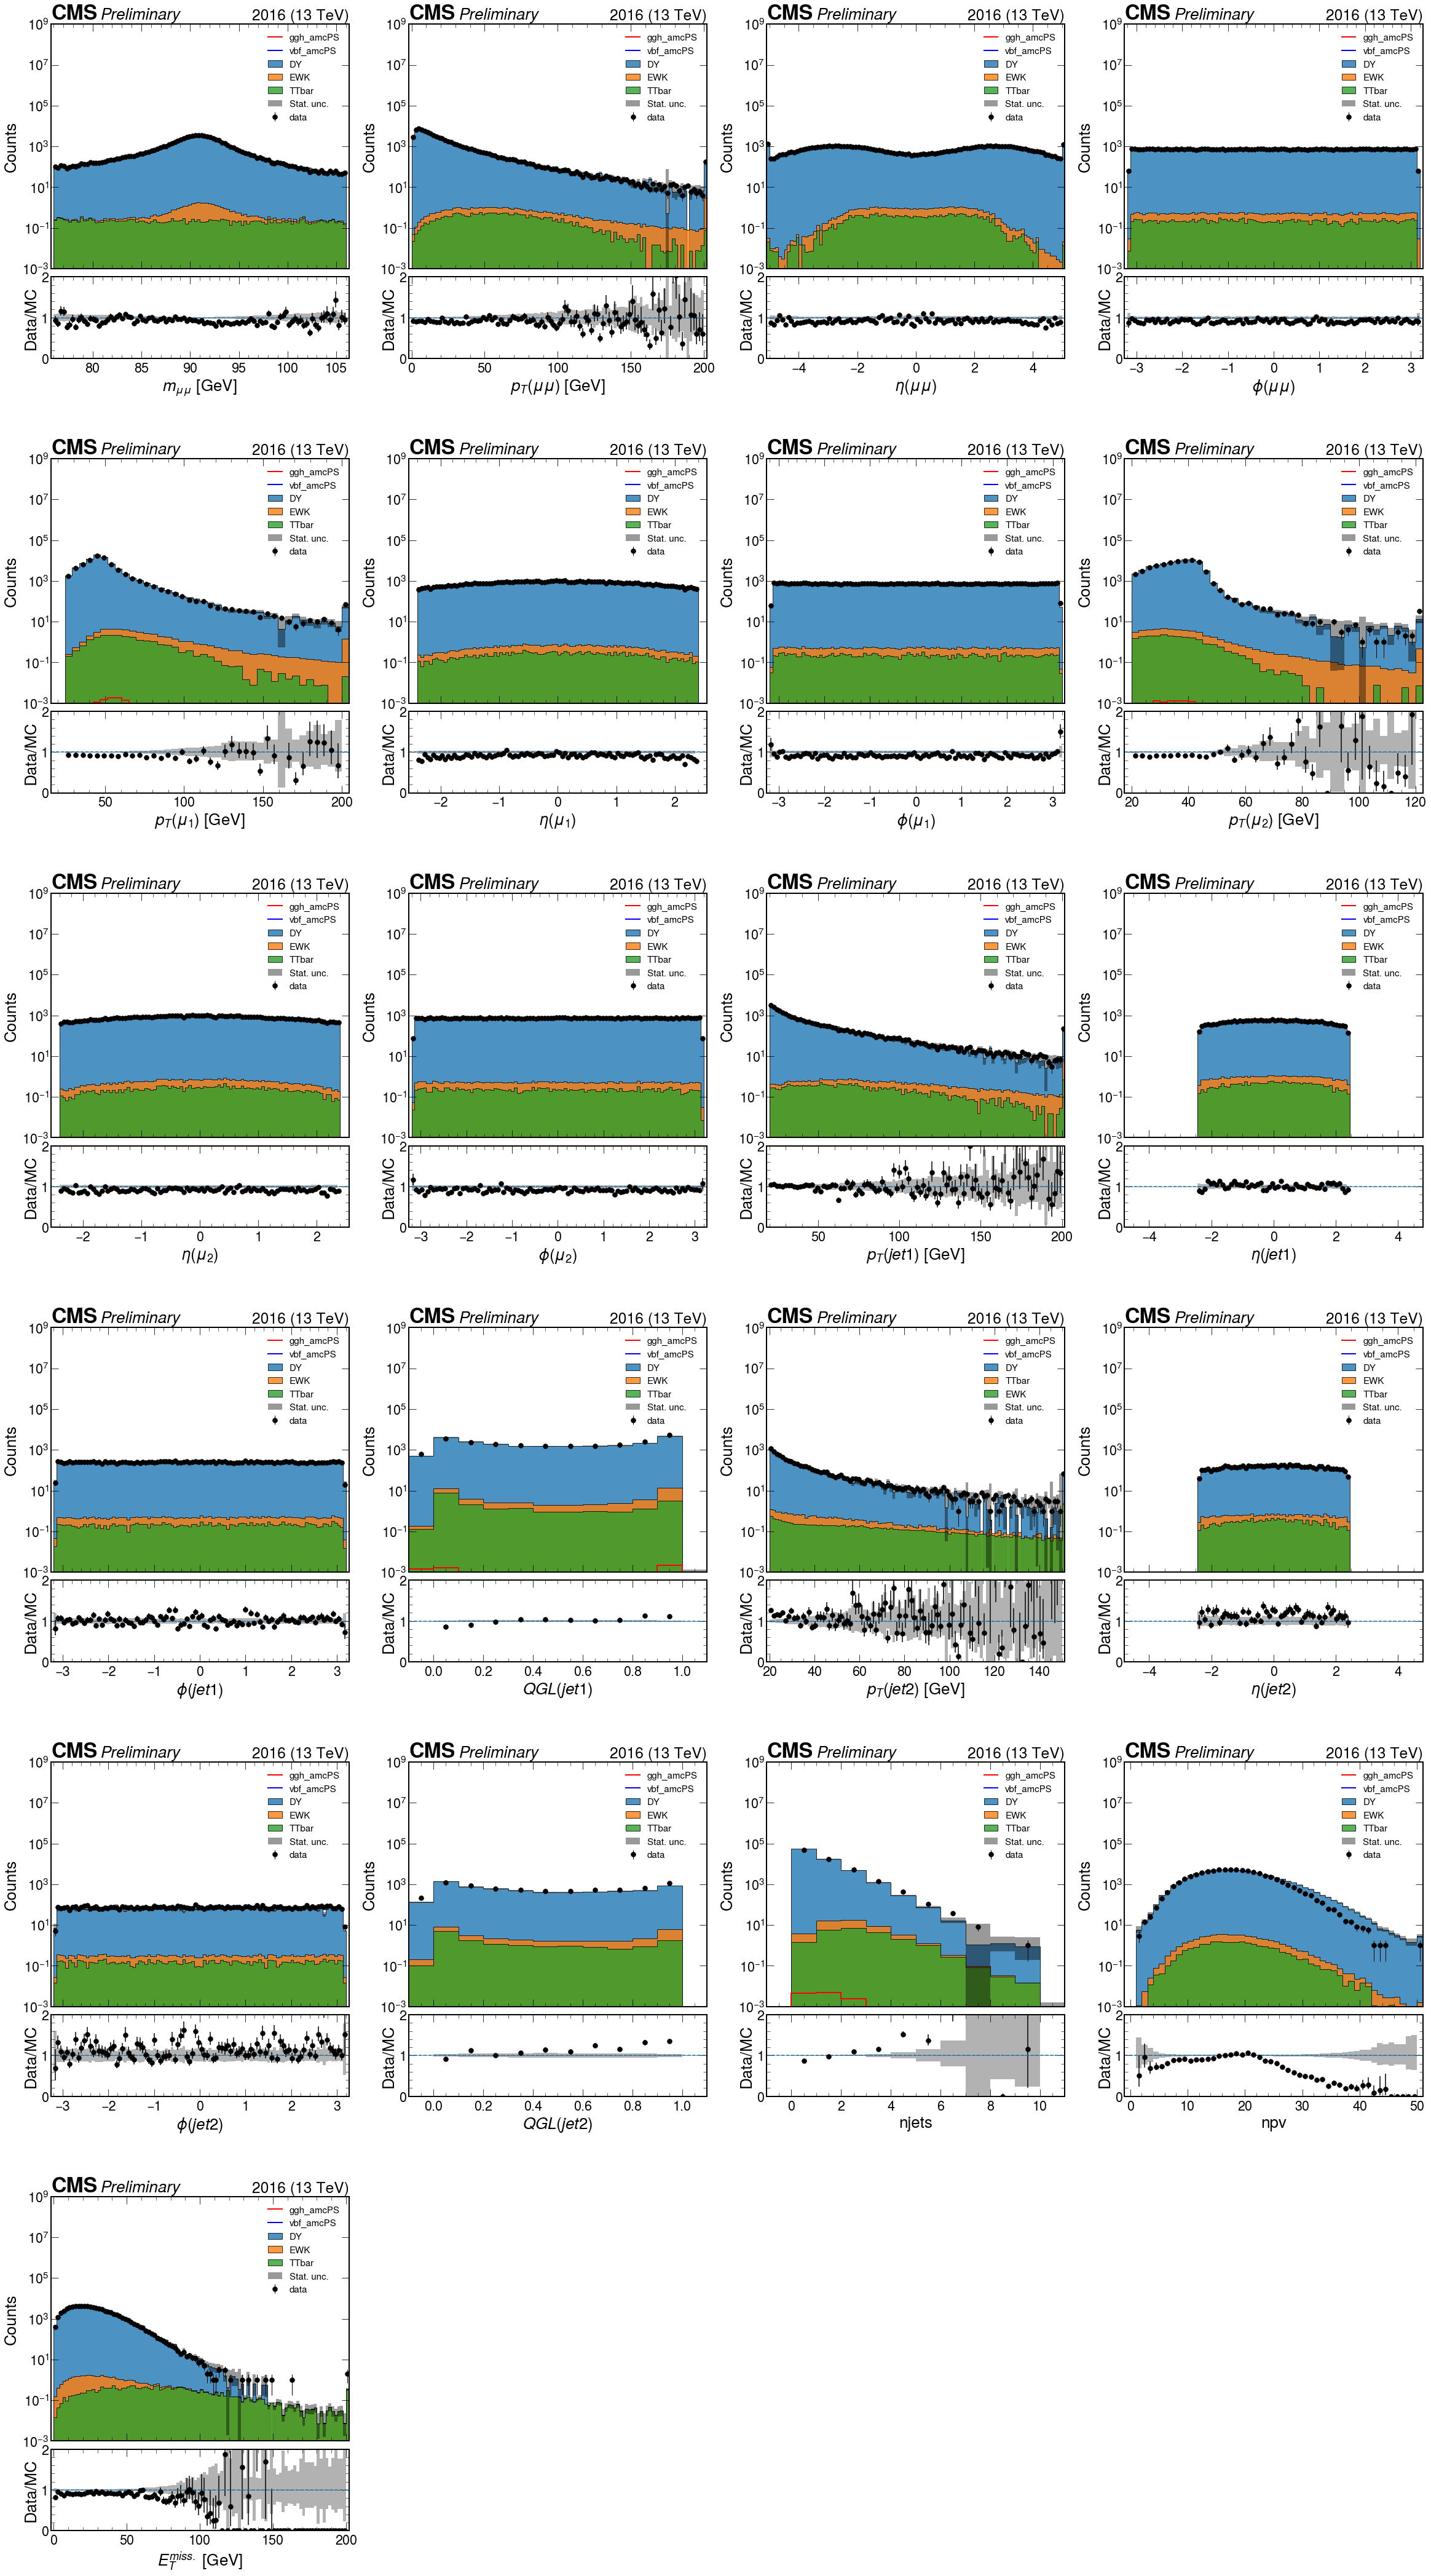

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.cms.style.ROOT)
from matplotlib import gridspec
import math
    
fig = plt.figure()
    
nplots_x = 4 # number of plots in one row
nplots_y = math.ceil(len(vars_to_plot) / nplots_x) # number of rows

plotsize=10
ratio_plot_size = 0.25
fig.set_size_inches(nplots_x*plotsize,nplots_y*plotsize*(1+ratio_plot_size))
outer_grid = gridspec.GridSpec(nplots_y, nplots_x, hspace = .3) 
for i, var in enumerate(vars_to_plot):
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer_grid[i], height_ratios=[(1-ratio_plot_size),ratio_plot_size], hspace = .05)
    plot_variable(fig, var, gs, lumi_weights)

Make plots in parallel
---

Faster, but can't display the plots in a grid. Maybe will use to save png/pdf plots.

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
import mplhep as hep
plt.style.use(hep.cms.style.ROOT)
import multiprocessing as mp

plt.rcParams['figure.dpi'] = 50
    
figs = {}
def plot_var(i):
    fig = plt.figure()
    plotsize=8
    ratio_plot_size = 0.24
    fig.set_size_inches(plotsize,plotsize*(1+ratio_plot_size))
    gs = gridspec.GridSpec(2, 1, height_ratios=[(1-ratio_plot_size),ratio_plot_size], hspace = .05)
    plot_variable(fig, vars_to_plot[i], gs, lumi_weights)
    return fig

pool = mp.Pool(mp.cpu_count() - 1)
results = [pool.apply(plot_var, args=(x,)) for x in range(len(vars_to_plot))]    
